In [3]:
from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[GpuElemwise{exp,no_inplace}(<GpuArrayType<None>(float32, vector)>), HostFromGpu(gpuarray)(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.247004 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [1]:
import theano

Using cuDNN version 6021 on context None
Preallocating 6553/8192 Mb (0.800000) on cuda0
Mapped name None to device cuda0: GeForce GTX 1080 (0000:01:00.0)


In [2]:
theano.config.dnn.include_path

'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v8.0\\include'

In [231]:
# http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import FloatTensor
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import copy

plt.ion()

In [280]:
data_mean, data_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = os.path.abspath('../../_data/hymenoptera_data')
image_datasets = {name: datasets.ImageFolder(os.path.join(data_dir, name), trans) for name, trans in data_transforms.items()}
data_loaders = {name: torch.utils.data.DataLoader(sets, batch_size=4, shuffle=True, num_workers=4)#, pin_memory=True)
                    for name, sets in image_datasets.items()}
dataset_size = {name: len(sets) for name, sets in image_datasets.items()}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    inp = data_std * inp + data_mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(data_loaders['train']))

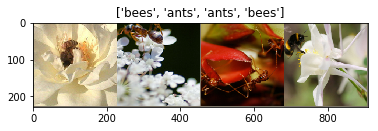

In [4]:
grids = torchvision.utils.make_grid(inputs)
imshow(grids, title=[class_names[i] for i in classes])

In [81]:
x = torch.FloatTensor()

In [201]:
x=torch.autograd.Variable(torch.FloatTensor([2]))
y=torch.autograd.Variable(torch.FloatTensor([5]))
a=torch.autograd.Variable(torch.FloatTensor([1]), requires_grad=True)
b=torch.autograd.Variable(torch.FloatTensor([0]), requires_grad=True)

In [217]:
loss = ((a * x + b) - y).pow(2).sum()

In [218]:
loss.backward()

In [211]:
x.data = torch.FloatTensor([3])
y.data = torch.FloatTensor([3*2+1])

In [205]:
x

Variable containing:
 2
[torch.FloatTensor of size 1]

In [206]:
a

Variable containing:
 1
[torch.FloatTensor of size 1]

In [220]:
a.grad

Variable containing:
-36
[torch.FloatTensor of size 1]

In [208]:
loss.data


 9
[torch.FloatTensor of size 1]

In [221]:
2*(a*x+b - y)*x

Variable containing:
-12
-24
[torch.FloatTensor of size 2]

In [216]:
x=torch.autograd.Variable(torch.FloatTensor([2, 3]))
y=torch.autograd.Variable(torch.FloatTensor([5, 3*2 + 1]))
a=torch.autograd.Variable(torch.FloatTensor([1]), requires_grad=True)
b=torch.autograd.Variable(torch.FloatTensor([0]), requires_grad=True)

In [230]:
a.grad.data.new().resize_as_(a.grad.data).zero_()


 0
[torch.FloatTensor of size 1]

In [311]:
def train_model(model, crit, opt, lr_sch, epochs):
    if use_gpu:
        model = model.cuda()
    best_model_wts = copy.deepcopy(model.state_dict())
    #device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    best_acc = 0.2
    for ep in range(epochs):
        for stage in ['train', 'val']:
            
            if stage == 'train':
                lr_sch.step(ep)
                model.train()
            else:
                model.eval()
            loader = data_loaders[stage]
            loss_sum = 0.0
            correct_sum = 0
            for x, y in loader:
                if use_gpu:
                    x, y = x.cuda(), y.cuda()
                x, y = Variable(x), Variable(y)
                # Forward:
                out = model(x)
                _, pred = torch.max(out.data, 1)
                loss = crit(out, y)
                
                if stage == 'train':
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                loss_sum += loss.data[0] * x.size(0)
                correct_sum += torch.sum(pred == y.data)
            epoch_loss = loss_sum / dataset_size[stage]
            epoch_acc = correct_sum / dataset_size[stage]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(stage, epoch_loss, epoch_acc))
            if stage == 'val' and epoch_acc > best_acc:
                best_model_wts = copy.deepcopy(model.state_dict())

In [312]:
model_ft = models.resnet18(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 2); model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [313]:
criterion = nn.CrossEntropyLoss()
opt_ft = optim.Adam(model_ft.fc.parameters())
exp_lr_scheduler = lr_scheduler.ExponentialLR(opt_ft, gamma=0.1)

In [314]:
for para in model_ft.parameters():
    para.require_grad = False
    
train_model(model_ft, criterion, opt_ft, exp_lr_scheduler, 5)

train Loss: 0.6295 Acc: 0.6557
val Loss: 0.3460 Acc: 0.8889
train Loss: 0.4972 Acc: 0.7705
val Loss: 0.3274 Acc: 0.8889
train Loss: 0.4877 Acc: 0.7910
val Loss: 0.3459 Acc: 0.8889
train Loss: 0.4808 Acc: 0.7910
val Loss: 0.3256 Acc: 0.8954
train Loss: 0.4624 Acc: 0.8279
val Loss: 0.3389 Acc: 0.8824


In [329]:
exp_lr_scheduler.get_lr()

[1.0000000000000002e-07]

In [277]:
a, b = next(iter(data_loaders['train']))

In [245]:
torch.max(b, 1)

RuntimeError: dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
tmp = model_ft(Variable(a))

In [284]:
torch.max(tmp, 1)

(Variable containing:
  0.2529
  0.6301
  0.4947
  0.1616
 [torch.FloatTensor of size 4], Variable containing:
  0
  0
  0
  0
 [torch.LongTensor of size 4])

In [333]:
model_ft.fc.weight.require_grad()

True